Bollinger Bands Trading Strategy Optimization, with specific 3x leveraged Bull/ Bear ETFs </br>

*   TQQQ - ProShares UltraPro QQQ ETF
*   SQQQ - ProShares UltraPro Short QQQ ETF
*   SPXL - Direxion Daily S&P 500 Bull 3X Shares ETF
*   SPXS - Direxion Daily S&P 500 Bear 3X Shares ETF
*   TZA  - Direxion Daily Small Cap Bear 3X ETF 
*   TNA  - Direxion Daily Small Cap Bull 3X ETF
*   SOXL - Direxion Daily Semiconductor Bull 3X Shares ETF
*   SOXS - Direxion Daily Semiconductor Bear 3X Shares ETF
*   FAS  - Direxion Daily Financial Bull 3x Shares ETF
*   FAZ  - Direxion Daily Financial Bear 3x Shares ETF
*   LABU - Direxion Daily S&P Biotech Bull 3X Shares ETF
*   LABD - Direxion Daily S&P Biotech Bear 3X Shares ETF
*   EDC  - Direxion Daily MSCI Emerging Markets Bull 3X Shares ETF
*   EDZ  - Direxion Daily MSCI Emerging Markets Bear 3X Shares ETF

</br>
ref: https://www.direxion.com/etfs?filter=bullbear3x

In [59]:
#!pip install yfinance --upgrade
#!pip install talib-binary
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
#!pip install Ta-Lib
#!pip install pandas-datareader
#!pip install PyPortfolioOpt

In [60]:
import os
import sys
import copy
from datetime import datetime, timedelta
import time
import itertools

import pandas as pd
import pandas_datareader as pdr
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import talib as ta
from talib import MA_Type

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import cla
from pypfopt import plotting

**1) Defining Data Folder Structures & Parameters**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
#data folder structures
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
backtest_output_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/backtest_output'

In [63]:
# pair inverse trade stocks
ticker_list = ['TQQQ', 'SQQQ', 'SPXL', 'SPXS', 'TZA', 'TNA', 'SOXL', 'SOXS', 'FAS', 'FAZ', 'LABD', 'LABU', 'EDZ', 'EDC']

# define date range
start_date = '2021-03-20'
end_date = '2022-12-31'
interval = '1d'

# initial capital in USD
initial_capital = 7000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**2) Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file 





In [64]:
# changing working directory to data folder's path
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
os.chdir(data_folder)

# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
# Other indicators: 14 day RSI
for ticker in ticker_list:
  try:
    globals()[ticker] = pd.DataFrame
    globals()[ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    globals()[ticker]['200EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=200) 
    globals()[ticker]['ATR'] = ta.ATR(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['RSI_14'] = ta.RSI(globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)
    globals()[ticker]['MFI'] = ta.MFI(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], globals()[ticker]['Volume'], 14)
    globals()[ticker]['WILL%R'] = ta.WILLR(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], timeperiod=14)

    # Bollinger Bands
    globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

    # add/drop columns and clean up
    globals()[ticker] = globals()[ticker].round(4).dropna()
    globals()[ticker] = globals()[ticker].reset_index()
    globals()[ticker][['Position', 'Win Count']] = 0
    globals()[ticker][['Lot Size', 'Equity Value', 'MDD_dollar', 'PNL', 'Holding Period']] = np.NAN
    
    #writing each ticker dataframe into separate .csv files, save to google drive
    #globals()[ticker].to_csv(ticker+'.csv', index=False, header=True)
  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADX** - globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>


**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>

**50 Day Exponential Moving Average** - globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50) </b>

**Bollinger Bands** - globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

**Stochastic Indicators** - globals()[ticker]['Stoch_slowk'], globals()[ticker]['Stoch_slowd'] = ta.STOCH(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'],                                                              fastk_period=21, slowk_period=5, slowk_matype=0, slowd_period=5, slowd_matype=0)    

**3) Building the DataFrame List, Perform Backtesting**

In [65]:
# list of dataframes to be iterated after yfinance data pull           
df_list = [TQQQ, SQQQ, SPXL, SPXS, TZA, TNA, SOXL, SOXS, FAS, FAZ, LABD, LABU, EDZ, EDC]

In [66]:
# function to extract dataframe name
def get_df_name(df):
   name =[x for x in globals() if globals()[x] is df][0]
   return name

In [67]:
# function to print function name as a string
def get_func_name(func_name):
    func_name = sys._getframe().f_code.co_name
    return func_name

**MACD Bollinger Bands Strategy**

*   Entry Rule: Open Price < Lower Bollinger Band, MACD > MACD signal line > 0
*   Exit Rule: Hit profit target/ stop loss/ last day of trade, MACD < signal line



In [68]:
# defining the global list for storing trade list output
global bb_macd_tradelist
bb_macd_tradelist = []

pos_size = round(initial_capital/len(ticker_list),2)

In [69]:
# defining a backtest function based on trading rules, capture all transactions

def backtest_bbmacd(df):
  df_name = get_df_name(df)

  pos_opened = False
  open_price  = 0
  close_price = 0
  lot_size = 0

  initial_equity_value = 0
  win_counter = 0
  open_trade_date = 0
  holding_days = 0

  pnl = 0
  pnl_list = []
    
  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi_14      = df.loc[i, 'RSI_14']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_MACD_hist   = df.loc[i, 'MACD_hist']
    now_bband_u     = df.loc[i, 'BBand_U']
    now_bband_m     = df.loc[i, 'BBand_M']
    now_bband_l     = df.loc[i, 'BBand_L']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']
    now_win_count   = df.loc[i, 'Win Count']

    # opening a position
    if (pos_opened == False and (now_open < now_bband_l and now_MACD > now_MACD_signal and now_MACD_hist > 0)):
      pos_opened = True
      open_trade_date = now_date
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      df.at[i, 'Position'] = 1
      df.at[i, 'Lot Size'] = lot_size
      df.at[i, 'Equity Value'] = initial_equity_value
      bb_macd_tradelist.append([now_date, df_name, pos_opened, open_price, lot_size, initial_equity_value])

    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True and ((now_MACD < now_MACD_signal) or \
                                  (lot_size * now_open > initial_equity_value * 1.2) or (lot_size * now_open < initial_equity_value * 0.95) or \
                                  (now_date == df.loc[(len(df)-1), 'Date']))):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      df.at[i, 'Position'] = 2
      df.at[i, 'Lot Size'] = lot_size
      df.at[i, 'Equity Value'] = (close_price * lot_size)
      if (now_open * lot_size) < initial_equity_value:
        df.loc[i, 'MDD_dollar']   = -(initial_equity_value - (now_open * lot_size))
      else:
        df.loc[i, 'MDD_dollar']   = 0
      holding_days = now_date - open_trade_date
      df.at[i, 'Holding Period'] = holding_days.days
      
      pnl = round(((close_price * lot_size) - sell_commission) - initial_equity_value,2)
      df.at[i, 'PNL'] = pnl.round(2)
      if pnl > 0:
        df.at[i, 'Win Count'] = 1
        win_counter += 1
      pnl_list.append(pnl)
      bb_macd_tradelist.append([now_date, df_name, pos_opened, close_price, lot_size, (close_price*lot_size), pnl, holding_days])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      lot_size = 0
      open_trade_date = 0

    else:
      df.loc[i, 'Equity Value']   = (now_open * lot_size)
      df.loc[i, 'Lot Size']       = lot_size
      if (now_open * lot_size) < initial_equity_value:
        df.loc[i, 'MDD_dollar']   = initial_equity_value - (now_open * lot_size)
      else:
        df.loc[i, 'MDD_dollar']   = 0

  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].min().round(2)
  avg_hold_period = df['Holding Period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

In [70]:
# create a for loop, put together trade summary list
bbmacd_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_bbmacd(df)
    bbmacd_result_list.append(test_result)

    bbmacd_result_df = pd.DataFrame(bbmacd_result_list)
    bbmacd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    test_result_null = bbmacd_result_list.append([df_name, 0, 0, 0, 0, 0, 0])
    bbmacd_result_df = pd.DataFrame(bbmacd_result_list)
    bbmacd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']

In [71]:
# PNL for Bollinger Bands + MACD Strategy

measure_date = df_list[1].loc[1, 'Date']
end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trading Strategy: Bollinger Bands + MACD')
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((bbmacd_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = bbmacd_result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (bbmacd_result_df['No of Trade'].sum()))
print('Total PNL: USD', bbmacd_result_df['Total PNL'].sum().round(2))
print('Capital Deployed: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg Win Rate: ', round(bbmacd_result_df[bbmacd_result_df['No of Trade'] > 0]['Win Rate %'].mean(),2), '%')
bbmacd_result_df[bbmacd_result_df['No of Trade'] > 0].sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)


Trading Strategy: Bollinger Bands + MACD
Trade period: 2022-01-04 to 2022-12-23
Total No of Trades Executed: 47
Total PNL: USD 3299.65
Capital Deployed: USD 7000
ROI:  47.14 %
Avg Win Rate:  82.86 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %
6,SOXL,4,468.80,117.20,0.00,4.75,100.00
7,SOXS,4,369.36,92.34,0.00,4.25,100.00
11,LABU,3,333.88,111.29,0.00,5.00,100.00
0,TQQQ,4,326.97,81.74,-8.69,10.50,75.00
5,TNA,4,324.46,81.11,0.00,9.00,100.00
2,SPXL,3,236.61,78.87,0.00,15.67,100.00
3,SPXS,3,232.48,77.49,0.00,5.00,100.00
4,TZA,2,213.86,106.93,0.00,3.50,100.00
12,EDZ,4,175.23,43.81,-4.76,8.25,75.00
9,FAZ,3,174.73,58.24,-29.50,4.33,66.67


**4) Other EDA Indicators**

In [72]:
# Extracting only close price from various dataframes
start = df_list[0].loc[1, 'Date']
end = df_list[0].loc[df.index[-1], 'Date'] 

df_close_price = []
df_close_price.append(df_list[0]['Date'].to_list())
bench_list = ['DX-Y.NYB', '^TNX']

for close_price in df_list:
  price = close_price['Close'].to_list()
  df_close_price.append(price)

for ticker in bench_list:
  bench_close = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=True, back_adjust=True, progress=False)['Close']
  df_close_price.append(bench_close)

# putting everything to a dataframe, adding the column headers
all_df = pd.DataFrame(df_close_price).T
all_df.columns = ['Date', 'TQQQ', 'SQQQ', 'SPXL', 'SPXS', 'TZA', 'TNA', 'SOXL', 'SOXS', 'FAS', 'FAZ', 'LABD', 'LABU', 'EDZ', 'EDC', 'USD Index', '10-yr T.Note']

# changing dataframe from object to numeric for plotting heatmap
for col in all_df.columns[1:]:
    all_df[col] = pd.to_numeric(all_df[col], errors='coerce')


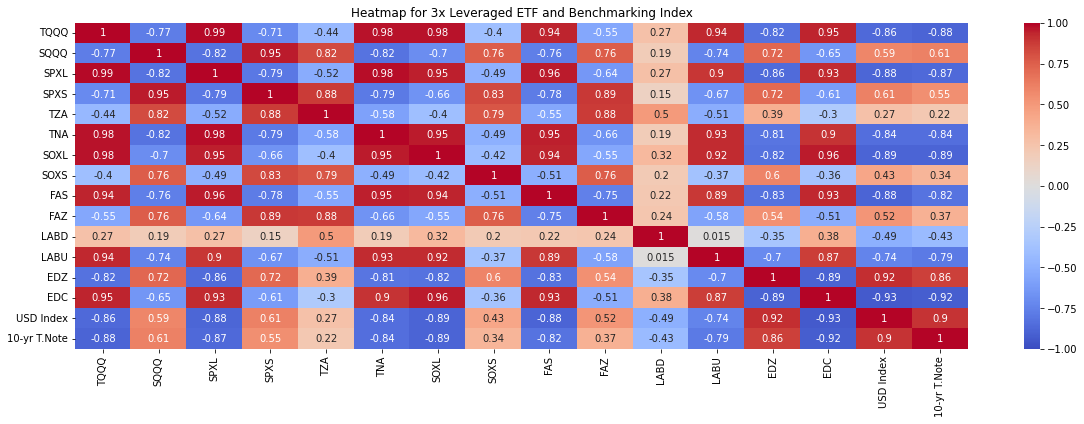

In [73]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for 3x Leveraged ETF and Benchmarking Index')
#mask = np.triu(np.ones_like(all_df.corr())) #--> add syntax mask=mask to produce diagonal heatmap
sns.heatmap(all_df.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm') #--> mask=mask to create diagonal heatmap

**5) Calculating the Sharpe Ratio**

In [74]:
all_df = all_df.drop(['USD Index', '10-yr T.Note'], axis=1)
all_df = all_df.set_index('Date')
all_df_pct = all_df.pct_change()
all_df_pct = all_df_pct.dropna()

In [101]:
sr = all_df_pct.mean()/all_df_pct.std() * np.sqrt(252)
sr

TQQQ   -1.190831
SQQQ    1.144396
SPXL   -0.821687
SPXS    0.814473
TZA     0.789951
TNA    -0.802221
SOXL   -0.905145
SOXS    0.827994
FAS    -0.477287
FAZ     0.460101
LABD    0.541784
LABU   -0.631533
EDZ     0.976745
EDC    -1.014296
dtype: float64

In [88]:
def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s

In [89]:
# Sharpe Ratio From Scratch
def sharpe_ratio(data, risk_free_rate=0.0):
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

In [75]:
buylist = ticker_list
weight = np.array([0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142,0.07142])

In [96]:
#calculating portfolio variance basd on stock buy list
cov_matrix_annual = all_df.cov()*253 #--> aveage nasdaq trading days
portfolio_variance = np.dot(weight.T, np.dot(cov_matrix_annual, weight))
print('Portfolio variance:', portfolio_variance.round(3))

Portfolio variance: 12334.569


In [97]:
#calculating portfolio volatility
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility.round(4)

111.0611

In [98]:
mu = expected_returns.ema_historical_return(all_df) 
s = risk_models.sample_cov(all_df)
ef = EfficientFrontier(mu, s)
weight_ef = ef.max_sharpe()
clean_weights = ef.clean_weights()
clean_weights

OrderedDict([('TQQQ', 0.2487),
             ('SQQQ', 0.25289),
             ('SPXL', 0.08008),
             ('SPXS', 0.07628),
             ('TZA', 0.11954),
             ('TNA', 0.11752),
             ('SOXL', 0.02007),
             ('SOXS', 0.01889),
             ('FAS', 0.002),
             ('FAZ', 0.00072),
             ('LABD', 0.00747),
             ('LABU', 0.0086),
             ('EDZ', 0.02362),
             ('EDC', 0.02364)])

In [99]:
ef.portfolio_performance(verbose=True)

Expected annual return: 31.7%
Annual volatility: 0.5%
Sharpe Ratio: 54.75


(0.3173579878244457, 0.005430727504889653, 54.754724400499576)

Downloading the Full Transaction List


In [80]:
full_trade = pd.DataFrame(bb_macd_tradelist)
full_trade.columns = ['Transaction Date', 'Ticker', 'Trade Opened', 'Unit Price', 'Lot Size', 'Equity Value', 'PNL', 'Holding Period']

In [81]:
full_trade.head()

,Transaction Date,Ticker,Trade Opened,Unit Price,Lot Size,Equity Value,PNL,Holding Period
0,2022-05-25,TQQQ,True,26.3035,19.0,499.5800,NaN,NaT
1,2022-05-31,TQQQ,False,33.1281,19.0,629.4339,129.08,6 days
2,2022-07-05,TQQQ,True,23.2891,21.0,488.8600,NaN,NaT
3,2022-07-20,TQQQ,False,28.5120,21.0,598.7520,109.04,15 days
4,2022-10-13,TQQQ,True,16.4347,30.0,492.7400,NaN,NaT


In [82]:
# export to csv
full_trade.to_csv('full_trade2012to2022.csv')